In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
vdata = pd.read_csv(
    "/home/sebastien/Documents/2021VAERSDATA.csv", encoding="iso-8859-1",
    usecols=lambda name: name != "SYMPTOM_TEXT")


/tmp/ipykernel_18807/3484194386.py:1: DtypeWarning: Columns (7,12,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  vdata = pd.read_csv(


In [3]:
num_rows = len(vdata)
perc_nan = {}
for col_name in vdata.columns:
    num_nans = len(vdata[col_name][vdata[col_name].isna()])
    perc_nan[col_name] = 100 * num_nans / num_rows
labels = perc_nan.keys()
bar_values = list(perc_nan.values())
x_positions = np.arange(len(labels))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_18807/1859027453.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


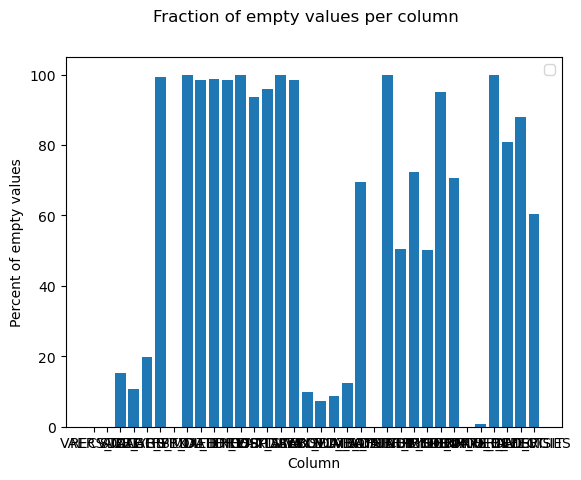

In [4]:
fig = plt.figure()
fig.suptitle("Fraction of empty values per column")
ax = fig.add_subplot()
ax.bar(x_positions, bar_values)
ax.set_ylabel("Percent of empty values")
ax.set_xlabel("Column")
ax.set_xticks(x_positions)
ax.set_xticklabels(labels)
ax.legend()
# fig.savefig("naive_chart.png")
fig.show()

In [5]:
fig = plt.figure(figsize=(16, 9), tight_layout=True, dpi=600)
fig.suptitle("Fraction of empty values per column", fontsize="48")
ax = fig.add_subplot()
b1 = ax.bar(x_positions, bar_values)
ax.set_ylabel("Percent of empty values", fontsize="xx-large")
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_xlim(-0.5, len(labels))
for i, x in enumerate(x_positions):
    ax.text(
        x, 2, "%.1f" % bar_values[i], rotation=90,
        va="bottom", ha="center",
        backgroundcolor="white")
fig.text(0.2, 0.01, "Column", fontsize="xx-large")
# fig.savefig("cleaner_chart.png")
fig.show()

/tmp/ipykernel_18807/1771546100.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [8]:
dead = vdata[vdata.DIED == "Y"]
vax = pd.read_csv("/home/sebastien/Documents/2021VAERSVAX.csv", encoding="iso-8859-1").set_index("VAERS_ID")

vax.groupby("VAX_TYPE").size().sort_values()

vax_dead = dead.join(vax, on="VAERS_ID", how="inner")
# join on id, discuss


vax_dead.iloc[0]

dead_counts = vax_dead["VAX_TYPE"].value_counts()
large_values = dead_counts[dead_counts >= 10]
other_sum = dead_counts[dead_counts < 10].sum()
large_values = large_values._append(pd.Series({"OTHER": other_sum}))

distance_df = vax_dead[vax_dead.DATEDIED.notna() & vax_dead.VAX_DATE.notna()]
distance_df["DATEDIED"] = pd.to_datetime(distance_df["DATEDIED"])
distance_df["VAX_DATE"] = pd.to_datetime(distance_df["VAX_DATE"])
distance_df = distance_df[distance_df.DATEDIED >= "2021"]
distance_df = distance_df[distance_df.VAX_DATE >= "2021"]
distance_df = distance_df[distance_df.DATEDIED >= distance_df.VAX_DATE]
time_distances = distance_df["DATEDIED"] - distance_df["VAX_DATE"]
time_distances_d = time_distances.astype(int) / (10**9 * 60 * 60 * 24)

date_died = pd.to_datetime(vax_dead[vax_dead.DATEDIED.notna()]["DATEDIED"])
date_died = date_died[date_died >= "2021"]
date_died_counts = date_died.value_counts().sort_index()
cum_deaths = date_died_counts.cumsum()

state_dead = vax_dead[vax_dead["STATE"].notna()][["STATE", "SEX"]]
top_states = sorted(state_dead["STATE"].value_counts().head(10).index)
top_state_dead = state_dead[state_dead["STATE"].isin(top_states)].groupby(["STATE", "SEX"]).size()#.reset_index()
top_state_dead.loc["MN", "U"] = 0  # XXXX
top_state_dead = top_state_dead.sort_index().reset_index()
top_state_females = top_state_dead[top_state_dead.SEX == "F"][0]
top_state_males = top_state_dead[top_state_dead.SEX == "M"][0]
top_state_unk = top_state_dead[top_state_dead.SEX == "U"][0]

fig, ((vax_cnt, time_dist), (death_time, state_reps)) = plt.subplots(
    2, 2,
    figsize=(16, 9), tight_layout=True, dpi=600)

vax_cnt.set_title("Vaccines involved in deaths")
wedges, texts = vax_cnt.pie(large_values)
vax_cnt.legend(wedges, large_values.index, loc="lower left")

time_dist.hist(time_distances_d, bins=50)
time_dist.set_title("Days between vaccine administration and death")
time_dist.set_xlabel("Days")
time_dist.set_ylabel("Observations")

death_time.plot(date_died_counts.index, date_died_counts, ".")
death_time.set_title("Deaths over time")
death_time.set_ylabel("Daily deaths")
death_time.set_xlabel("Date")
tw = death_time.twinx()
tw.plot(cum_deaths.index, cum_deaths)
tw.set_ylabel("Cummulative deaths")

state_reps.set_title("Deaths per state stratified by sex")
state_reps.bar(top_states, top_state_females, label="Females")
state_reps.bar(top_states, top_state_males, label="Males", bottom=top_state_females)
state_reps.bar(top_states, top_state_unk, label="Unknown",
               bottom=top_state_females.values + top_state_males.values)
state_reps.legend()
state_reps.set_xlabel("State")
state_reps.set_ylabel("Deaths")

fig.savefig("summary.png")

/tmp/ipykernel_18807/3229614278.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_df["DATEDIED"] = pd.to_datetime(distance_df["DATEDIED"])
/tmp/ipykernel_18807/3229614278.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_df["VAX_DATE"] = pd.to_datetime(distance_df["VAX_DATE"])
